**This example is used to demostrate the tool**

In [1]:
#Import our modules
import Service
import GlOb
import Comm 
import exeAreas
import exeMgn

#import modules for API
from API import srcAPI as src
from API import sinkAPI as sink
from API import FMUAPI
from API import MatlabAPI
from API import PythonAPI
#import necessary services such as Server to connect remote components
from API.comm_protos.TCP import TCPServer as Server

#import general modules from python
import time
import os

In [2]:
#import libraries from  models that are created in Pyton
#Models made in python
from Models import SpringProp

#import dataProcess unit also made in python.. with the rules stated in the code
from Models.dataProcess import CurrentSens

In [3]:
#Create all  interfaces

directory = os.getcwd() + '\\' + 'Models'

############## sensor inteface ###########################################
sens = src.Sensor(name  = 'current_sensor', config = {"type" : "freq", 'unit': 's', 'occurrences_per_unit':2},
                    sending_port = 55000, receiving_ports = [55001], 
                    outputsNames = ['current'])
sensName = 'current_sensor'
sens.save_to_csv(file_name=sensName)

############### Sink interface ##################################################
monitor = sink.Sink (comm_proto = 'TCP-IP', 
                    name  = 'coil_monitor', config = {"type" : "freq", "unit": "s", "occurrences_per_unit":1},
                    instruction_port = 60000, sending_ports=[60001, 60002,60003], 
                    inputsNames = ['position', 'mass','T_coil'])
sinkName =  "coil_monitor"
monitor.save_to_csv(file_name=sinkName)

################### Data Process unit interface

DatProcc = CurrentSens()
DataProc = PythonAPI.Wrapping(model = DatProcc,directory=directory,
                                 modelName = 'DPCurrentSens', typ = 'DataProc',
                                 inputsNames= ['rawData'], outputsNames= ['eCurrent'])
DP_name = 'DPCurrentSens'
DataProc.save_to_csv(file_name=DP_name)
######################################### Python model ########################################

#create python object from the model
SProperty_model = SpringProp.Model()

#Encapsulate the model to store its attributes 
inputsNames = ['R']
outputsNames = ['T_coil','k']
springProp_model = PythonAPI.Wrapping(model=SProperty_model, directory=directory,
                                      modelName='SpringProp',inputsNames=inputsNames, 
                                      outputsNames=outputsNames, exeSchedule={1:'execute'},
                                      printFlag=True)

SprinP_name = 'SpringProp'
springProp_model.save_to_csv(file_name=SprinP_name)
########################################### FMU Models #########################################
#not really needed for FMUs:

ElectricalHeat = FMUAPI.FMU(modelName='ElectricalHeat', directory=directory)

MassSpringKInput = FMUAPI.FMU(modelName='MassSpringKInput', directory=directory)

RiceCooker = FMUAPI.FMU(modelName='RiceCooker', directory=directory)

Data of the class has been extracted
For type DataProc the complete execution will be performed only by a method called: processData 
no parameters
Inputs and outputs have been defined for this model
Data of the class has been extracted
Inputs and outputs have been defined for this model
{'ports': ['R', 'T_coil', 'k', 'param'], 'methods': ['Tcoil_calculation', 'execute', 'k_calculation']}


In [4]:
#Component Manager

#instanciate all the components: by defining inputs, outputs and parameters 
# always as a dictionary {'name': , 'unit': , 'datatype'}


####################### #sensor component #########################################
output = {'name':"current", 'unit':'Amp', 'datatype':'JSON','val':''}
outputs = [output]

current_sens = Comm.Source(name = 'current_sensor',outputs = outputs)

################################ sink component #####################################
# 'position', 'mass','T_coil'
input1 = {'name':"position", 'unit':'m', 'datatype':'float','val':''}
input2 = {'name':"mass", 'unit':'kg', 'datatype':'float','val':''}
input3 = {'name':"T_coil", 'unit':'C', 'datatype':'float','val':''}
inputs = [input1,input2,input3]

coil_monitor =  Comm.Sink(name='coil_monitor',inputs=inputs)

######################## Data process component ####################################
directory = os.getcwd() + '\\' + 'Models'

input = {'name':"rawData", 'unit':'Amp', 'datatype':'JSON','val':''}
inputs = [input]
output = {'name':"eCurrent", 'unit':'Amp', 'datatype':'float','val':''}
outputs = [output]

dataprocess1 = Comm.Model(name='DPCurrentSens',SimE='Python',modelDir=directory, 
                          inputs=inputs,outputs=outputs, parameters=[])

######################### Python model: Spring Properties###########################
input1 = {'name':"R", 'unit':"ohms", 'datatype':"float",'val':''}

inputs = [input1]

output1 = {'name':"T_coil", 'unit':"C", 'datatype':"float",'val':''}
output2 ={'name':"k", 'unit':"N/m", 'datatype':"float",'val':''}
outputs = [output1,output2]

parameter1 = {'name':"R_25", 'unit':"ohms", 'datatype':"float",'val':'15'}
parameter2 = {'name':"alpha", 'unit':"-", 'datatype':"float",'val':'0.0039'}
parameter3 = {'name':"d_wire", 'unit':"mm", 'datatype':"float",'val':'0.127'}
parameter4 = {'name':"d_coil", 'unit':"mm", 'datatype':"float",'val':'1'}
parameter5 = {'name':"N", 'unit':"-", 'datatype':"float",'val':'9.25'}
parameters = [parameter1,parameter2,parameter3,parameter4,parameter5]

springProp = Comm.Model(name = 'SpringProp',SimE= "Python",modelDir = directory, 
                    inputs=inputs,outputs=outputs, parameters= parameters)

########################FMU model:##################################################
########################Electrical Heat#############################################
input1 = {'name':"I", 'unit':"Amps", 'datatype':"float",'val':''}
inputs = [input1]

output1 = {'name':"Q", 'unit':"Watts", 'datatype':"float",'val':''}
output2 = {'name':"R", 'unit':"Ohms", 'datatype':"float",'val':''}
outputs = [output1,output2]

parameter1 = {'name':"V", 'unit':"Vots", 'datatype':"float",'val':'150'}
parameters = [parameter1]

elecHeat = Comm.Model(name = 'ElectricalHeat', SimE = 'FMU', modelDir=directory,
                    inputs=inputs, outputs=outputs, parameters=parameters)

########################  Cooker spring #############################################
input1 = {'name':"Force", 'unit':"N", 'datatype':"float",'val':''}
input2 = {'name':"k", 'unit':"N/m", 'datatype':"float",'val':''}
inputs = [input1,input2]

output1 = {'name':"DisplacementOutput", 'unit':"m", 'datatype':"float",'val':''}
outputs = [output1]

parameter1 = {'name':"dampingCoefficient", 'unit':"m", 'datatype':"float",'val':'-0.5'}
parameter2 = {'name':"mass", 'unit':"kg", 'datatype':"float",'val':'0.01'}
parameters = [parameter1,parameter2]

cookSpring = Comm.Model(name = 'MassSpringKInput', SimE = 'FMU', modelDir=directory,
                    inputs=inputs, outputs=outputs, parameters=parameters)


######################## Rice cooker  #############################################
input1 = {'name':"Q", 'unit':"Watts", 'datatype':"float",'val':''}
inputs = [input1]

output1 = {'name':"mass_rice", 'unit':"kg", 'datatype':"float",'val':''}
output2 = {'name':"T_rice", 'unit':"kg", 'datatype':"float",'val':''}
outputs = [output1,output2]

parameter1 = {'name':"T_0", 'unit':"C", 'datatype':"float",'val':'18'}
parameter2 = {'name':"m_0", 'unit':"kg", 'datatype':"float",'val':'1.5'}
parameters = [parameter1,parameter2]

riceCooker = Comm.Model(name = 'RiceCooker', SimE = 'FMU', modelDir=directory,
                    inputs=inputs, outputs=outputs, parameters=parameters)

######################## Rice cooker configuration  #############################################

input1 = {'name':"T_0", 'unit':"C", 'datatype':"float",'val':'18'}
input2 = {'name':"m_0", 'unit':"kg", 'datatype':"float",'val':'1.5'}
inputs = [input1,input2]

confRiceCooker = Comm.ConfigComp(name = 'confRiceCooker', modelDir = directory, SimE = 'FMU',
                                 inputs=inputs, outputs= None, ModelObj=riceCooker)

The variables defined are connsistent with the sensor component current_sensor
The variables defined are connsistent with the sink component coil_monitor
Data of the class has been extracted
For type DataProc the complete execution will be performed only by a method called: processData 
no parameters
Inputs and outputs have been defined for this model
Data of the class has been extracted
Inputs and outputs have been defined for this model


In [5]:
# In this section I also define connection components if needed. 

# A duplicator for the mass output is needed, also transformator in after that duplication

##################### duplicator#####################
input ={'name':'mass','unit' : 'kg', 'datatype':'float','val':0}
dup1 = Comm.Duplicator(input=input,num_outputs=3)

########################### Transformator #############################
outputs= [{'name': 'Force', 'unit' : 'N', 'datatype':'float','val':'10'}]
inputs =[{'name':'mass','unit' : 'kg', 'datatype':'float','val':'100'}]
exp = 'Force = -9.8*mass'
vars = {'mass':1.5}

transform = Comm.Transformation(outputs=outputs, inputs=inputs, 
                            expressions=exp, variables=vars)


For duplicator duplicator776, the names of the outputs are:
mass0
mass1
mass2
 For transformator Transformator254, all outputs define in the equations are correct
For transformator Transformator254, all variables within the equations are correctly defined


In [6]:
#Communication manager

#define all the connections. 
# First I define each input and output. 

###################### Connection definition #####################################
# first define the connection handler
# sensor and monitor current_sens ('current'), coil_monitor ( 'position', 'mass','T_coil')
# data process unit dataprocess1 (rawData /  eCurrent)
# models:
# springProp (R/ T_coil, k) elecHeat (I/Q)  
# cookSpring (Force, k/DisplacementOutput) riceCooker (Q/mass_rice,T_rice)

# conector components dup1(mass/mass0,mass1,mass2)  transform(mass/Force)



###### Output Sensor###############
sensSrc1 = {'component': current_sens, 'output': 'current'}
####### Input monitor###############
sinkDst1 = {'component': coil_monitor, 'input': 'position'}
sinkDst2 = {'component': coil_monitor, 'input': 'mass'}
sinkDst3 = {'component': coil_monitor, 'input': 'T_coil'}
####### Input/output data processor unit###############
DPUSrc1 = {'component': dataprocess1, 'output': 'eCurrent'}
DPUDst1 = {'component': dataprocess1, 'input': 'rawData'}
####### Input/output springProp###############
SprPSrc1 = {'component': springProp, 'output': 'k'}
SprPSrc2 = {'component': springProp, 'output': 'T_coil'}
SprPDst1 = {'component': springProp, 'input': 'R'}
####### Input/output elecHeat###############
elecHeatSrc1 = {'component': elecHeat, 'output': 'Q'}
elecHeatSrc2 = {'component': elecHeat, 'output': 'R'}
elecHeatDst1 = {'component': elecHeat, 'input': 'I'}
####### Input/output cookSpring###############
cookSprDst1 = {'component': cookSpring, 'input': 'Force'}
cookSprDst2 = {'component': cookSpring, 'input': 'k'}
cookSprSrc1 = {'component': cookSpring, 'output': 'DisplacementOutput'}
####### Input/output riceCooker###############
RiceCookSrc1 = {'component': riceCooker, 'output': 'mass_rice'}
RiceCookSrc2 = {'component': riceCooker, 'output': 'T_rice'} #missing to confRiceCook
RiceCookDst1 = {'component': riceCooker, 'input': 'Q'}
####### Input/output confRiceCooker###############
ConfRiceCookDst1 = {'component': confRiceCooker, 'input': 'm_0'}
ConfRiceCookDst2 = {'component': confRiceCooker, 'input': 'T_0'} 

####### Input/output dup1###############

DupSrc3 = {'component': dup1, 'output': 'mass2'} #-> to confRiceCook
DupSrc2 = {'component': dup1, 'output': 'mass1'}
DupSrc1 = {'component': dup1, 'output': 'mass0'}
DupDst1 = {'component': dup1, 'input': 'mass'}

####### Input/output transform###############
TransfSrc1 = {'component': transform, 'output': 'Force'}
TransfDst1 = {'component': transform, 'input': 'mass'}

connections = exeMgn.ConnectionHandler()
#types of exchange patters used here:

fifo = {'type': 'FIFO'}
LVoC = {'type': 'LVoC'}
LVQ = {'type': 'LVQ'}

# connections
connections.connect(source=sensSrc1,destination=DPUDst1,exPattern=fifo)

connections.connect(source=DPUSrc1,destination=elecHeatDst1,exPattern=LVQ)

connections.connect(source=elecHeatSrc1,destination=RiceCookDst1,exPattern=fifo)
connections.connect(source=elecHeatSrc2,destination=SprPDst1,exPattern=fifo)

connections.connect(source=RiceCookSrc1,destination=DupDst1,exPattern=fifo)
connections.connect(source=RiceCookSrc2,destination=ConfRiceCookDst2,exPattern=LVoC)

connections.connect(source=DupSrc1,destination=sinkDst2,exPattern=LVoC)
connections.connect(source=DupSrc2,destination=TransfDst1,exPattern=fifo)
connections.connect(source=DupSrc3,destination=ConfRiceCookDst1,exPattern=LVoC)

connections.connect(source=TransfSrc1,destination=cookSprDst1,exPattern=fifo)

connections.connect(source=SprPSrc1,destination=cookSprDst2,exPattern=fifo)
connections.connect(source=SprPSrc2,destination=sinkDst3,exPattern=LVoC)

connections.connect(source=cookSprSrc1,destination=sinkDst1,exPattern=LVoC)

# connections.connect(source=sensSrc1,destination=DPUDst1)
# connections.connect(source=sensSrc1,destination=DPUDst1)
# connections.connect(source=sensSrc1,destination=DPUDst1)
# connections.connect(source=sensSrc1,destination=DPUDst1)
print(connections)


Connections are:
id:Conn0 ('current_sensor', 'current')->('DPCurrentSens', 'rawData')
id:Conn1 ('DPCurrentSens', 'eCurrent')->('ElectricalHeat', 'I')
id:Conn2 ('ElectricalHeat', 'Q')->('RiceCooker', 'Q')
id:Conn3 ('ElectricalHeat', 'R')->('SpringProp', 'R')
id:Conn4 ('RiceCooker', 'mass_rice')->('duplicator776', 'mass')
id:Conn5 ('RiceCooker', 'T_rice')->('confRiceCooker', 'T_0')
id:Conn6 ('duplicator776', 'mass0')->('coil_monitor', 'mass')
id:Conn7 ('duplicator776', 'mass1')->('Transformator254', 'mass')
id:Conn8 ('duplicator776', 'mass2')->('confRiceCooker', 'm_0')
id:Conn9 ('Transformator254', 'Force')->('MassSpringKInput', 'Force')
id:Conn10 ('SpringProp', 'k')->('MassSpringKInput', 'k')
id:Conn11 ('SpringProp', 'T_coil')->('coil_monitor', 'T_coil')
id:Conn12 ('MassSpringKInput', 'DisplacementOutput')->('coil_monitor', 'position')



Defult triggers will be used, no triggers as input
Correct guard definition for trigger StoptriggerSrcArea808


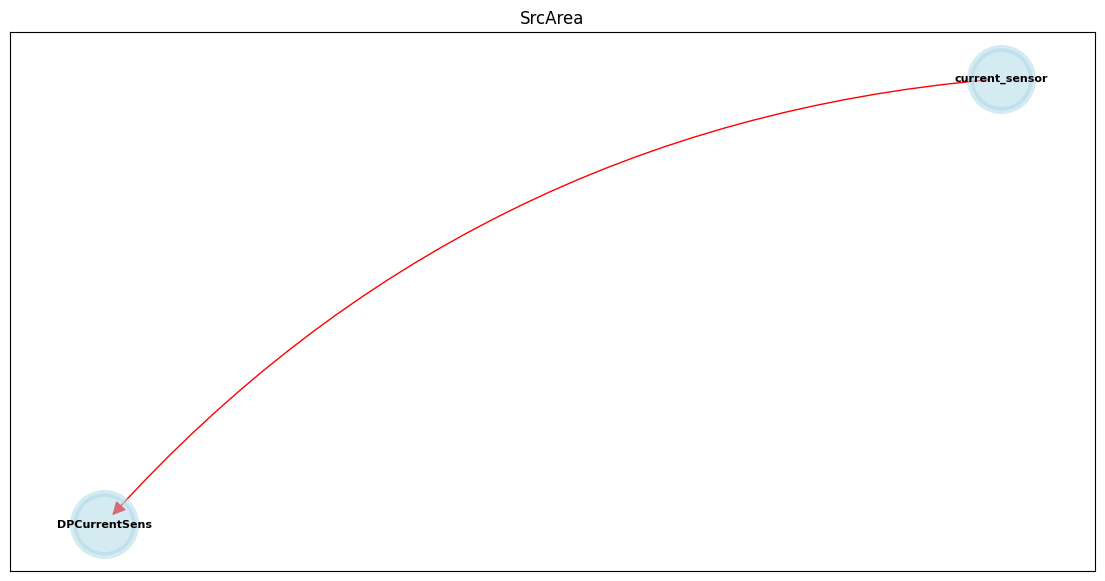

Correct guard definition for trigger StoptriggerCosimArea276


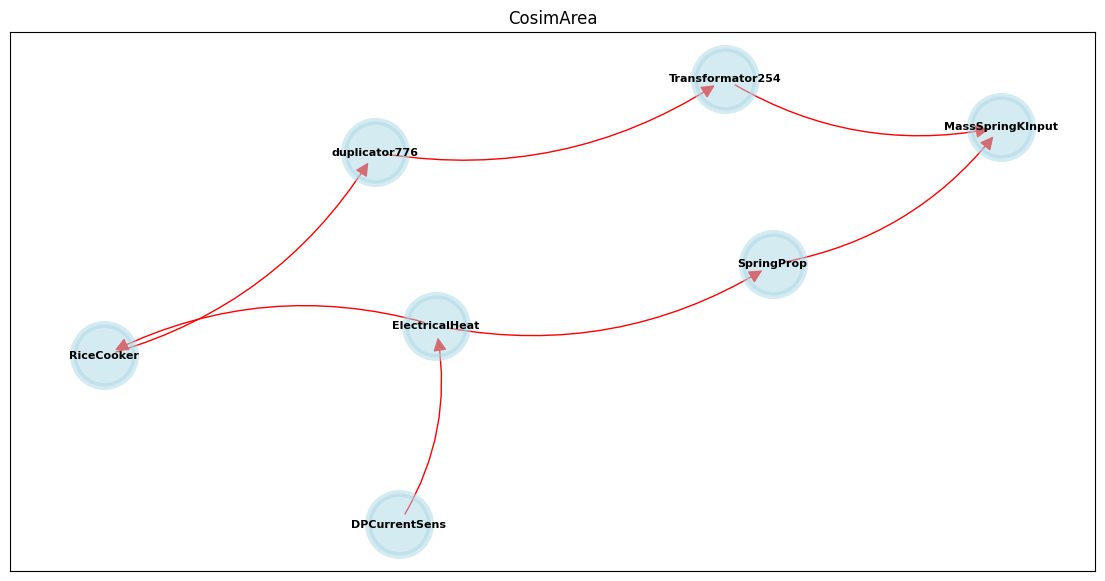

Correct guard definition for trigger StoptriggerConfigArea274


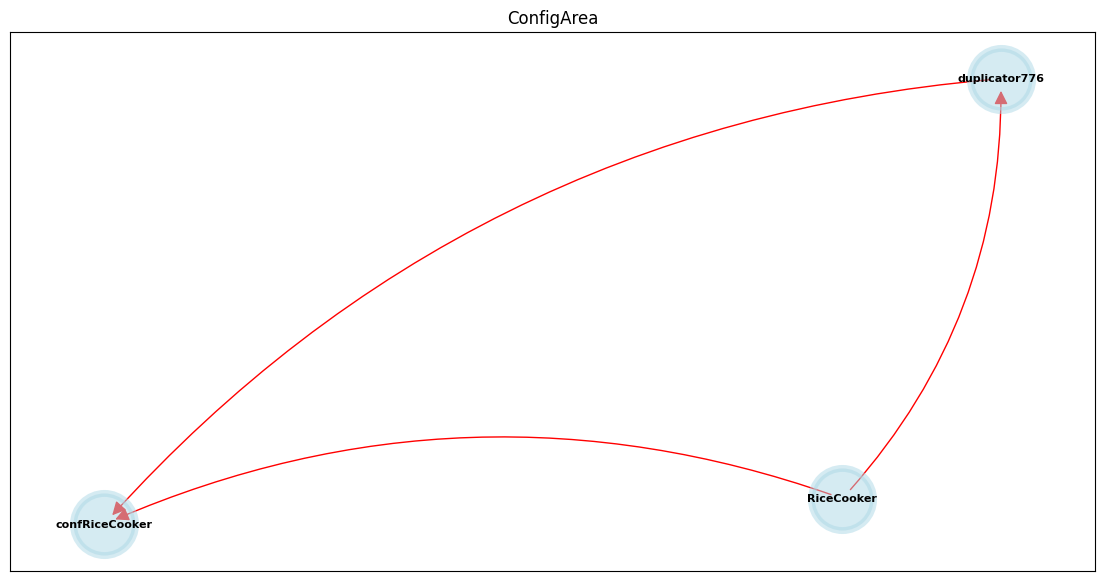

The continuos exection will execute based on the frequence of the inputs arriving to the models

Correct guard definition for trigger StoptriggerSinkArea781


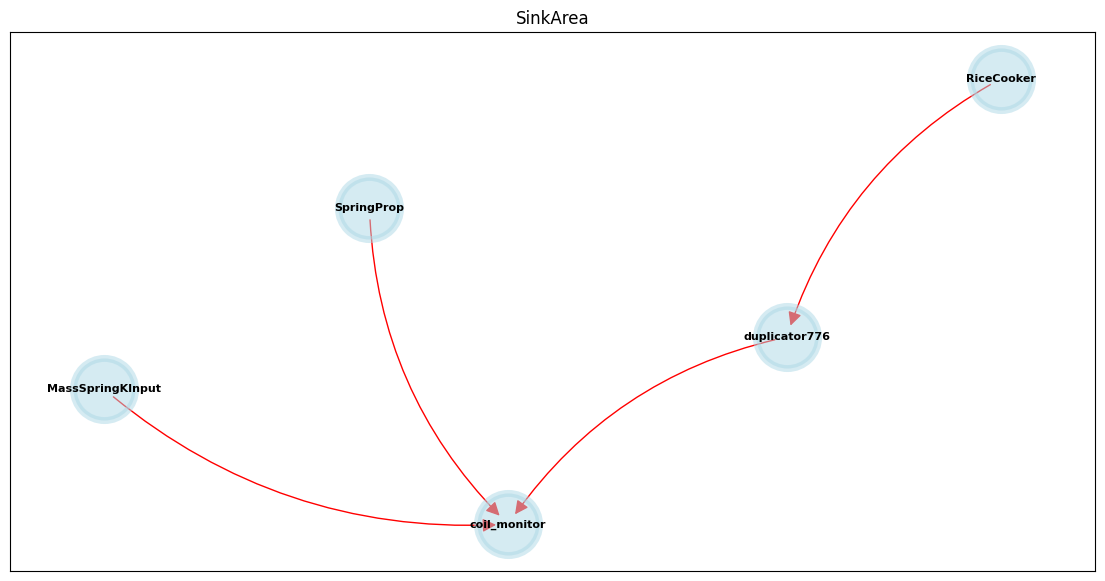

In [7]:
# Execution  manager
#generate and define all areas of execution

AppTime = GlOb.AppTime()
globals = GlOb.GlobalVars()

# sensor and monitor current_sens ('current'), coil_monitor ( 'position', 'mass','T_coil')
# data process unit dataprocess1 (rawData /  eCurrent)
# models:
# springProp (R/ T_coil, k) elecHeat (I/Q)  
# cookSpring (Force, k/DisplacementOutput) riceCooker (Q/mass_rice,T_rice)

# conector components dup1(mass/mass0,mass1)  transform(mass/Force)

#all componnets must be defined to feed the areas
allComponents = [globals,current_sens,coil_monitor,dataprocess1,
                 springProp,elecHeat,cookSpring,riceCooker,
                 dup1,transform, confRiceCooker]

areaSource = exeMgn.srcExe(name = 'SrcArea',components=[current_sens,dataprocess1],
                             exec_type='time_specific', triggers=[],
                             delayTime=2,allComponents=allComponents,appTime=AppTime)

startTrigger = {'type':'start', 'class':'data','definition':'ElectricalHeat.I'}
triggers = [startTrigger]
config = {'exeTime':'FTRT','exeConf':{'t_ini':(0,'s'),'t_period':(10,'s'), 't_step':(1,'s')}}
areaCosim =  exeMgn.cosim(name='CosimArea', components=[elecHeat,springProp,riceCooker,cookSpring,transform,dup1],
                            simexec_type='time_based',triggers=triggers,configuration=config,
                            allComponents=allComponents,appTime=AppTime)

startTrigger = {'type':'start', 'class':'data','definition':'confRiceCooker.m_0'}
triggers = [startTrigger]
areaConfig = exeMgn.cosim(name = 'ConfigArea', components=[confRiceCooker],
                          simexec_type='continuous',triggers=triggers,
                          allComponents=allComponents,appTime=AppTime)

startTrigger = {'type':'start', 'class':'data','definition':'coil_monitor.position'}
triggers = [startTrigger]
areaSink = exeMgn.sinkExe(name = 'SinkArea', components=[coil_monitor],
                            exec_type='streaming',triggers=triggers,
                            delayTime=3, allComponents=allComponents,appTime=AppTime)

In [8]:
for comp in areaConfig.newExeComponents:
    print(comp.name)
print('----------------------------------------------------------')
for comp in areaCosim.newExeComponents:
    print(comp.name)
print('----------------------------------------------------------')
for comp in areaSink.exeComponents:
    print(comp.name)
print('----------------------------------------------------------')
for comp in areaSource.exeComponents:
    print(comp.name)
print('----------------------------------------------------------')

confRiceCooker
----------------------------------------------------------
ElectricalHeat
SpringProp
RiceCooker
duplicator776
Transformator254
MassSpringKInput
----------------------------------------------------------
coil_monitor
----------------------------------------------------------
current_sensor
DPCurrentSens
----------------------------------------------------------


In [9]:
areaConfig.newExeComponents

In [10]:
areas = [areaSource,areaCosim,areaConfig,areaSink]
Ss = Service.MainManager(exeAreas=areas,globals=globals,appTime=AppTime)

In [11]:
# Start server
ports = [55000,55001,60001,60002,60000,60003,60004]
server = Server(ports=ports)
server.start_server()

Server is running on port 55000.
Listening on port 55000...
Server is running on port 55001.
Listening on port 55001...
Server is running on port 60001.
Listening on port 60001...
Server is running on port 60002.
Listening on port 60002...
Server is running on port 60000.
Listening on port 60000...
Server is running on port 60003.
Listening on port 60003...
Server is running on port 60004.
Listening on port 60004...


In [13]:
Ss.startService()

---------------------------------------------
Service execution has started
---------------------------------------------
---------------------------------------------
SrcArea has been initialized
---------------------------------------------
Connected to server on send port 55000.
Connection from ('127.0.0.1', 60401) on port 55000
Connection from ('127.0.0.1', 60402) on port 55001
Connected to server on receive port 55001.
Data Processing does not need to be initialized, it will recieve its first input from sources
already started the eng
*******Model DPCurrentSens has been initialized**********


*********************************************
Message sent: {"config": {"type": "freq", "unit": "s", "occurrences_per_unit": 1}}
---------------------------------------------
CosimArea has been initialized
---------------------------------------------
*******Model ElectricalHeat has been initialized**********


*********************************************
Model SpringProp has been initiated



component current_sensor :


component DPCurrentSens :
pulling data from connector
{'rawData': ['current', '1', '2025-01-13 16:24:39', "{'current': 3.49255890335158}"]}
{'eCurrent': 3.49255890335158}


+++++++++++++++++++++++++++++++++++++++++++++
CosimArea has started its execution
+++++++++++++++++++++++++++++++++++++++++++++

***********************Execution of areaCosimArea***********************

---------------- time is 0 ----------------------


component ElectricalHeat :
{'I': 0}
{'Q': 0.0, 'R': inf}


component SpringProp :
----------------------stuck: SpringProp------------------
Trying to pull data from connector model SpringProp
pulling data from connector
{'R': inf}
{'T_coil': inf, 'k': -inf}


component RiceCooker :
----------------------stuck: RiceCooker------------------
Trying to pull data from connector model RiceCooker
pulling data from connector
{'Q': 0.0}
{'mass_rice': 1.5, 'T_rice': 18.0}


component duplicator776 :
pulling data from connector
('output0_dup1', {

Exception in thread Thread-31 (areaExec):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "d:\Git_folders\projects_app\LOTTS\Service.py", line 50, in areaExec
    area.execute()
  File "d:\Git_folders\projects_app\LOTTS\exeMgn.py", line 596, in execute
    self.continuous(defintion=self.defintion)
                              ^^^^^^^^^^^^^^
AttributeError: 'cosim' object has no attribute 'defintion'. Did you mean: 'definition'?




iteration is:9




component current_sensor :


component DPCurrentSens :
pulling data from connector
{'rawData': ['current', '47', '2025-01-13 16:32:19', "{'current': 4.03116813564702}"]}
{'eCurrent': 4.03116813564702}
pulling data from connector
{'I': 4.03116813564702}
{'Q': 5101.649053767504, 'R': 37.21005796646692}


component SpringProp :
----------------------stuck: SpringProp------------------
Trying to pull data from connector model SpringProp
pulling data from connector
{'R': 37.21005796646692}
{'T_coil': 404.6591105378961, 'k': 252.80434113309778}


component RiceCooker :
----------------------stuck: RiceCooker------------------
Trying to pull data from connector model RiceCooker
pulling data from connector
{'Q': 5101.649053767504}
{'mass_rice': 1.5, 'T_rice': 21.618014563477033}


component duplicator776 :
pulling data from connector
('output0_dup1', {'name': 'mass0', 'value': 1.5})
('output1_dup1', {'name': 'mass1', 'value': 1.5})
('output2_dup1', {'name': 'mass2', 'value